In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Read the data into a dataframe
df = pd.read_csv("cleaned_data.csv")

# Separate the features and target variable
X = df[
    [
        "total_direct_mentions",
        "total_indirect_mentions",
        "total_likes",
        "total_retweets",
        "total_project_followers",
        "total_indirect_followers",
        "total_positive_direct_mentions",
        "total_negative_direct_mentions",
        "total_positive_indirect_mentions",
        "total_negative_indirect_mentions",
        "soft_cap",
    ]
]
y = df["ico_success"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [2]:
X_train

,total_direct_mentions,total_indirect_mentions,total_likes,total_retweets,total_project_followers,total_indirect_followers,total_positive_direct_mentions,total_negative_direct_mentions,total_positive_indirect_mentions,total_negative_indirect_mentions,soft_cap
448,1600,22972,20927,10742,2801,603520,424,596,2619,9565,9800000
335,20900,143143,269584,232138,27785,5427931,2741,5814,23647,52311,110000
294,8370,90488,111816,90380,12105,2613058,3653,3267,41936,16493,500000
684,1320,7653,14547,19429,2068,156207,597,355,1675,2486,17540000
79,1290,11772,18325,12310,2512,174368,390,376,3219,3555,200000
...,...,...,...,...,...,...,...,...,...,...,...
71,6850,11298,100308,70442,7538,2127502,2501,1510,3347,1148,2480000
106,14000,195544,121878,168014,14617,6255127,2994,3284,97209,52331,14800000
270,1170,7303,7974,13793,1747,248832,466,222,899,2764,1720000
435,21900,317392,312988,163780,30256,7739102,9362,8364,101679,79251,2400000


In [3]:
X_test

,total_direct_mentions,total_indirect_mentions,total_likes,total_retweets,total_project_followers,total_indirect_followers,total_positive_direct_mentions,total_negative_direct_mentions,total_positive_indirect_mentions,total_negative_indirect_mentions,soft_cap
196,577,5884,5848,5110,1126,280814,237,151,1618,1568,350000
299,7430,51847,92471,106743,7851,2567484,3464,1743,8669,15029,200000
744,343,4197,4710,2659,537,120299,115,54,1118,1863,14380000
227,3810,50737,40124,44982,5588,1638490,1172,1355,20919,16599,2400000
541,2530,11240,26216,35871,5057,1164264,748,1210,3870,2234,20000000
...,...,...,...,...,...,...,...,...,...,...,...
442,2220,17613,2870,33044,3165,600087,831,283,4608,2724,20000000
760,5160,45335,74535,75333,8452,2099396,1990,1897,19376,16358,600000
714,1370,16194,7668,6965,2215,184729,505,352,2003,5676,30000000
666,17700,248127,121476,27234,23488,7241039,4804,1976,54022,90326,30000000


# Neural Network

To get started, we use a very simple classification problem and a very simple multi-layer perceptron architecture.

## Imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.datasets import make_classification
from torch import nn

from skorch import NeuralNetClassifier
from skorch.helper import SkorchDoctor

In [5]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

In [6]:
plt.style.use("seaborn-v0_8")

## Load data

In [7]:
X, y = X_train.to_numpy().astype(np.float32), y_train.to_numpy().astype(np.int64)
X_test, y_test = X_test.to_numpy().astype(np.float32), y_test.to_numpy().astype(
    np.int64
)

In [8]:
X.shape, y.shape, y.mean()

((652, 11), (652,), 0.7285276073619632)

### Definition of the `PyTorch` classification `module`

This is just an MLP with two hidden layers.

In [9]:
class ClassifierModule(nn.Module):

    def __init__(
        self,
        num_features=11,
        num_units=1024,
        n_classes=2,
        nonlin=F.relu,
        dropout=0.1,
        depth=2,
        batchnorm=True,
    ):
        super(ClassifierModule, self).__init__()
        self.num_features = num_features
        self.num_units = num_units
        self.n_classes = n_classes
        self.nonlin = nonlin
        self.batchnorm = batchnorm
        self.depth = depth

        self.dense0 = nn.Linear(self.num_features, self.num_units)
        self.nonlin = self.nonlin
        self.dropout = nn.Dropout(dropout)

        layers = []
        for i in range(1, self.depth):
            layers.append(nn.Linear(self.num_units, self.num_units))
        self.dense1 = nn.Sequential(*layers)

        self.output = nn.Linear(self.num_units, self.n_classes)
        self.bn = nn.BatchNorm1d(self.n_classes)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = self.nonlin(self.dense1(X))
        X = self.output(X)

        if self.batchnorm:
            X = self.bn(X)

        X = F.softmax(X, dim=-1)
        return X

In [10]:
device = (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)  # use gpu

device

device(type='cuda')

In [11]:
net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=50,
    lr=0.01,
    batch_size=32,
    device=device,

    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [12]:
%%time

from sklearn.model_selection import GridSearchCV
net = NeuralNetClassifier(
    ClassifierModule,
    lr=0.001,
    device=device,

    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)

params = {
    "lr": [0.001, 0.005, 0.1],
    'batch_size': [20, 40, 60],
    'max_epochs': [10, 20, 30, 40],
    "module__num_units": list(range(50, 101, 5)),
    "module__depth": list(range(2, 9)),
    "module__dropout": [i * 0.1 for i in range(6)],
}

gs = GridSearchCV(net, params, refit=False, cv=3, n_jobs=-1, verbose=1, scoring="accuracy")

grid_result = gs.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 16632 candidates, totalling 49896 fits


/home/inflaton/miniconda3/envs/ico/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/inflaton/miniconda3/envs/ico/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
1 fits failed out of a total of 49896.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/inflaton/miniconda3/envs/ico/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_par

Best: 0.739258 using {'batch_size': 40, 'lr': 0.001, 'max_epochs': 20, 'module__depth': 6, 'module__dropout': 0.0, 'module__num_units': 65}
0.694732 (0.038801) with: {'batch_size': 20, 'lr': 0.001, 'max_epochs': 10, 'module__depth': 2, 'module__dropout': 0.0, 'module__num_units': 50}
nan (nan) with: {'batch_size': 20, 'lr': 0.001, 'max_epochs': 10, 'module__depth': 2, 'module__dropout': 0.0, 'module__num_units': 55}
0.726990 (0.002518) with: {'batch_size': 20, 'lr': 0.001, 'max_epochs': 10, 'module__depth': 2, 'module__dropout': 0.0, 'module__num_units': 60}
0.708557 (0.028539) with: {'batch_size': 20, 'lr': 0.001, 'max_epochs': 10, 'module__depth': 2, 'module__dropout': 0.0, 'module__num_units': 65}
0.714701 (0.023145) with: {'batch_size': 20, 'lr': 0.001, 'max_epochs': 10, 'module__depth': 2, 'module__dropout': 0.0, 'module__num_units': 70}
0.726976 (0.009931) with: {'batch_size': 20, 'lr': 0.001, 'max_epochs': 10, 'module__depth': 2, 'module__dropout': 0.0, 'module__num_units': 75}


/home/inflaton/miniconda3/envs/ico/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [0.69473217        nan 0.72699023 ... 0.72851929 0.72851929 0.72851929]
  warnings.warn(


## Use skorch doctor

So far, everything we did was just as you would always proceed when working with PyTorch and skorch. Next step, however, is where `SkorchDoctor` enters the picture. We wrap the `net` inside the `SkorchDoctor` class. This wrapper class takes care of adding a bunch of hooks to the PyTorch module that enable us to collect important data.

In [33]:
best_params = {
    "batch_size": 40,
    "lr": 0.001,
    "max_epochs": 20,
    "module__depth": 6,
    "module__dropout": 0.0,
    "module__num_units": 65,
}

In [46]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

In [47]:
best_net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.001,
    batch_size=40,
    module__depth=6,
    module__num_units=65,
    module__dropout=0.0,
    device=device,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [48]:
doctor = SkorchDoctor(best_net)

### Train the doctor

The `SkorchDoctor` instance itself can be used like any ordinary estimator, i.e. you can fit it, call `predict` on it etc. For us to study the training process, we need to fit the instance with our training data. However, it is recommended to use only a very small amount of data, like 100 samples, and train for a small number of epochs, like 5 in this example:

In [49]:
doctor.fit(X[:650], y[:650])

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7011       0.6077        0.6821  0.1490
      2        0.6907       0.5769        0.6857  0.1252
      3        0.6895       0.6231        0.6876  0.1272
      4        0.6877       0.6308        0.6861  0.1178
      5        0.6848       0.7000        0.6840  0.1100
      6        0.6850       0.7154        0.6837  0.1136
      7        0.6810       0.6923        0.6821  0.1150
      8        0.6840       0.7231        0.6815  0.1158
      9        0.6802       0.7385        0.6778  0.1133
     10        0.6778       0.7231        0.6778  0.1138
     11        0.6780       0.7385        0.6743  0.1220
     12        0.6778       0.7231        0.6736  0.1083
     13        0.6758       0.7385        0.6724  0.1156
     14        0.6714       0.7154        0.6727  0.1166
     15        0.6741       0.7154        0.6727  0.1193
     16        0.6718       0.7

(0.65, 0.75)

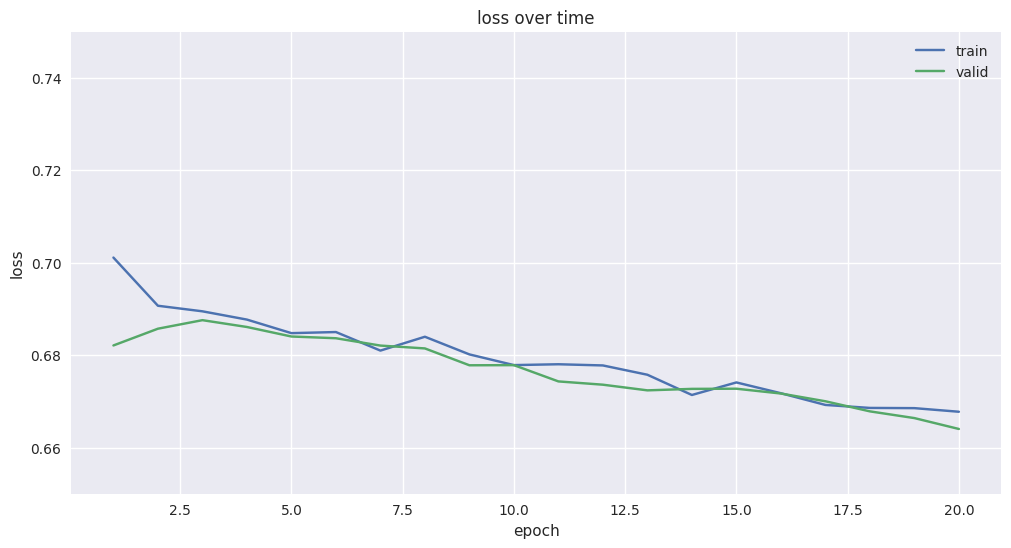

In [50]:
_, ax = plt.subplots(figsize=(12, 6))
doctor.plot_loss(ax=ax)
ax.set_ylim([0.65, 0.75])